In [2]:
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
import dlib
print("🌫🛸")

🌫🛸


작업폴더 만들기

이미지 저장하기

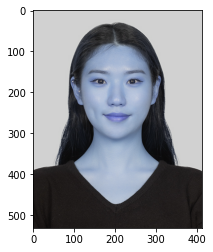

In [3]:
my_image_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/증명.jpg'
img_bgr = cv2.imread(my_image_path)    # OpenCV로 이미지를 불러옵니다
img_show = img_bgr.copy()      # 출력용 이미지를 따로 보관합니다
plt.imshow(img_bgr)
plt.show()

opencv에서 가져온 이미지를 보정하기

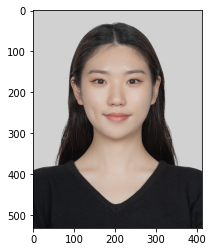

In [4]:
# plt.imshow 이전에 RGB 이미지로 바꾸는 것을 잊지마세요. 
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.show()

얼굴 검출 face detection

In [5]:
# detector를 선언합니다
detector_hog = dlib.get_frontal_face_detector()
print("🌫🛸")

🌫🛸


In [6]:
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
dlib_rects = detector_hog(img_rgb, 1)   # (image, num of image pyramid)
print("🌫🛸")

🌫🛸


rectangles[[(118, 118) (304, 304)]]


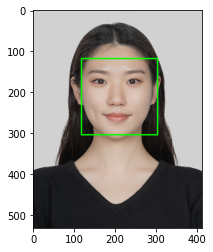

In [7]:
# 찾은 얼굴 영역 박스 리스트
# 여러 얼굴이 있을 수 있습니다
print(dlib_rects)   

for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()

    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)

img_show_rgb =  cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

얼굴 랜드마크 face landmark

In [8]:
model_path = os.getenv('HOME')+'/aiffel/camera_sticker/models/shape_predictor_68_face_landmarks.dat'
landmark_predictor = dlib.shape_predictor(model_path)
print("🌫🛸")

🌫🛸


In [9]:
list_landmarks = []

# 얼굴 영역 박스 마다 face landmark를 찾아냅니다
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    # face landmark 좌표를 저장해둡니다
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)

print(len(list_landmarks[0]))

68


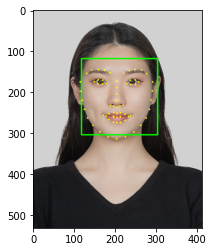

In [10]:
for landmark in list_landmarks:
    for point in landmark:
        cv2.circle(img_show, point, 2, (0, 255, 255), -1)

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

스티커 적용하기

In [40]:
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    print (landmark[30]) # 코의 index는 30 입니다
    x = landmark[30][0]
    y = landmark[10][1] 
    w = int((landmark[30][0]  - landmark[36][0]) * 2.1)  #: 왼쪽 눈끝
    h = int((landmark[48][1]  - landmark[2][1])  * 2.1)   # 왼쪽 입끝을 기준으로 고양이 수염 이미지의 크기를 맞춤
    print ('(x,y) : (%d,%d)'%(x,y))
    print ('(w,h) : (%d,%d)'%(w,h))

(204, 221)
(x,y) : (204,297)
(w,h) : (115,75)


In [41]:
sticker_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/24674.png'
img_sticker = cv2.imread(sticker_path) # 스티커 이미지를 불러옵니다
img_sticker = cv2.resize(img_sticker, (w,h))
print (img_sticker.shape)

(75, 115, 3)


In [42]:
refined_x = x - w // 2
refined_y = (int(y - h*1.5))
print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

(x,y) : (147,184)


In [43]:
if refined_x < 0: 
    img_sticker = img_sticker[:, -refined_x:]
    refined_x = 0
if refined_y < 0:
    img_sticker = img_sticker[-refined_y:, :]
    refined_y = 0

print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

(x,y) : (147,184)


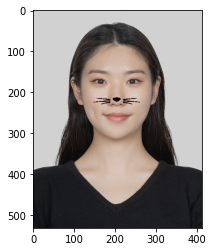

In [44]:
plt.imshow(img_show_rgb)
plt.show()

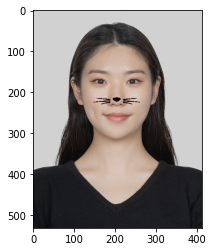

In [45]:
sticker_area = img_bgr[refined_y:refined_y +img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_bgr[refined_y:refined_y +img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==0,img_sticker,sticker_area).astype(np.uint8)
plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
plt.show()

In [46]:
img_show = img_bgr.copy()

In [39]:
img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
new_img_rgb = cv2.addWeighted(img_rgb, 0.5, img_show_rgb, 0.5, 0)

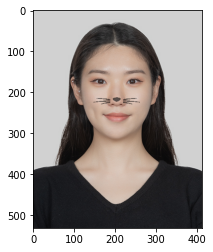

In [38]:
plt.imshow(new_img_rgb)
plt.show()

## 회고

이번 exploration은 너무 어려웠다.  
좌표 찾는 부분이 어려웠는데 운이 좋게 쉽게 맞게 되었다.  
아직 개념이나 코드 내용이 전반적으로 이해가 되지 않아서 다른 사진을 시도하지 못했다.  
고양이 수염 스티커의 배경이 자꾸 흰색으로 나와서 투명으로 바꾸는데 많은 시간을 소요했다.  
 np.where(img_sticker==0,img_sticker,sticker_area).astype(np.uint8)이 부분에서 img_sticker과 sticker_area 부분을 자리를 바꿔서 성공하긴 했으나 아직 어떤 원리로 그렇게 되었는지 잘 이해가 되지 않는다.  
다른 사진들으로도 시도해 봤는데 정확도가 현저하게 떨어져서 이에 대한 추가적으로 공부가 필요해 보인다. 

<문제점 찾아보기>

실행속도는 중요하다. 여러가지 실제로 카메라 앱에서 인공지능이 스티커를 어디에 어떻게 적용할지 오래 걸린다면 사람들은 더 이상 이 앱을 사용하지 않을 것이기 때문이다.

정확도는 중요하다고 생각한다. 예를 들어서 안경 스티커라고 가정했을 때 정확도가 떨어져서 입에 스티커가 실행이 된다면 이상하기 때문이다. 하지만 정확도가 떨어져서 이상한 곳에 붙으면 재미가 있을 수는 있을 것 같다.